In [2]:
import os
import datetime
from time import sleep

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import mse

DEBUG=False
start = datetime.datetime.now()

# carrega o conjunto de dados
if DEBUG:
    workload = pd.DataFrame({'cpu':[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13,  15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86,  88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99]})
else:
    workload = pd.read_csv('m_3330.csv', 
                 names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                          'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
    workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
    workload.set_index('time_stamp', inplace=True)
    workload = workload.resample('1min').interpolate()
    
# separa treino e teste
test_len = len(workload)//3
train_set = workload.cpu[:-test_len]
test_set = workload.cpu[-test_len:]
train_set.shape, test_set.shape

# TREINO
reshaped_train_set = np.reshape(workload.cpu[:-test_len].values, (-1, 1)) # carrega os dados de CPU em 2D
normalizer = MinMaxScaler(feature_range = (0,1)) # normaliza os valores entre 0 e 1
normalized_train_set = normalizer.fit_transform(reshaped_train_set)

previsors = []
expected_values = []

for i in range(10,len(reshaped_train_set)):
    previsors.append(normalized_train_set[i-10:i,0]) # guarda listas de 90 valores (Ex: posições 0 a 89)
    expected_values.append(normalized_train_set[i,0])# guarda o valor seguinte da lista para a rede prever (Ex: posição 90)
    
eps = [5,10]
dps = (2,2,2)
max_p, max_d, max_q = dps

params_set = []
for p in range(max_p+1):
    for d in range(max_d+1):
        for q in range(max_q+1):
            for epoch in eps:
                params_set.append((epoch, p/10,d/10,q/10))
models = []
errors = []
for params in params_set:
    epoch, d1, d2, d3 = params
    previsors, expected_values = np.array(previsors), np.array(expected_values)
    previsors = np.reshape(previsors,(previsors.shape[0], previsors.shape[1],1)) # [[previsors, expected_values]]  Novo shape: (train_len-90, 90, 1)

    regressor = Sequential()
    regressor.add(LSTM(units = 100,
                       return_sequences = True,
                       input_shape = (previsors.shape[1],1)))
    regressor.add(Dropout(d1))
    regressor.add(LSTM(units = 50,
                       return_sequences = True,))
    regressor.add(Dropout(d2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(d3))
    regressor.add(Dense(units = 1,
                        activation = 'linear'))
    regressor.compile(optimizer = 'rmsprop',
                      loss = 'mean_squared_error',
                      metrics = ['mean_absolute_error'])
    regressor.fit(previsors,
                  expected_values,
                  epochs = epoch,
                  batch_size = 32,
                  verbose=0)
    models.append(regressor)
    
    # Carga do modelo e previsão
    inputs = workload.cpu[len(workload.cpu) - len(test_set) - 10:].values
    inputs = inputs.reshape(-1,1)
    inputs = normalizer.transform(inputs)

    predict = []
    for j in range(10,len(test_set)):
        predict.append(inputs[j-10:j, 0])
    predict = np.array(predict)
    predict = np.reshape(predict,
                         (predict.shape[0],
                          predict.shape[1],
                          1))
    predict = regressor.predict(predict)
    predict = normalizer.inverse_transform(predict)
    
    # Organiza resultados do modelo
    result = workload[-test_len+10:-10].copy()
    result['predict'] = predict[10:]
    
    # valida o erro do modelo
    error = mse(result['cpu'], result['predict'])
    errors.append(error)
    print(f'{epoch} {params[1:]} {error}', end=' | ')
    
best_model = None
best_params = None
for model, params, error in zip(models, params_set, errors):
    best_error = min(errors)
    if error == best_error:
        best_model = model
        best_params = params 

print('\n\n')
print(f'Melhor resultado:\n\tÉpocas: {best_params[0]}\n\tDropouts: {tuple(best_params[1:])}\n\tErro: {best_error}')
lapsed = datetime.datetime.now() - start
print('Tempo: '+str(lapsed).split('.')[0])


5 (0.0, 0.0, 0.0) 37.76566075553719 | 10 (0.0, 0.0, 0.0) 42.312824434861376 | 5 (0.0, 0.0, 0.1) 41.13824946640545 | 10 (0.0, 0.0, 0.1) 36.96746693904449 | 5 (0.0, 0.0, 0.2) 44.36816128963654 | 10 (0.0, 0.0, 0.2) 36.57773208138527 | 5 (0.0, 0.1, 0.0) 37.314825425219794 | 10 (0.0, 0.1, 0.0) 36.298033335837225 | 5 (0.0, 0.1, 0.1) 40.81574532663157 | 10 (0.0, 0.1, 0.1) 36.223980241972896 | 5 (0.0, 0.1, 0.2) 49.34592426107655 | 10 (0.0, 0.1, 0.2) 35.88645827593841 | 5 (0.0, 0.2, 0.0) 36.285137334297985 | 10 (0.0, 0.2, 0.0) 36.24873093282923 | 5 (0.0, 0.2, 0.1) 36.417234867821506 | 10 (0.0, 0.2, 0.1) 39.282069152636154 | 5 (0.0, 0.2, 0.2) 36.80911857160422 | 10 (0.0, 0.2, 0.2) 39.78930009591044 | 5 (0.1, 0.0, 0.0) 37.11905242958004 | 10 (0.1, 0.0, 0.0) 51.07329936170935 | 5 (0.1, 0.0, 0.1) 42.53618005436083 | 10 (0.1, 0.0, 0.1) 37.63362171519365 | 5 (0.1, 0.0, 0.2) 38.9182707429526 | 10 (0.1, 0.0, 0.2) 37.636248904302946 | 5 (0.1, 0.1, 0.0) 36.315327253705945 | 10 (0.1, 0.1, 0.0) 39.25051769

In [3]:
regressor = best_model

In [4]:
# Carga do modelo e previsão
inputs = workload.cpu[len(workload.cpu) - len(test_set) - 10:].values
inputs = inputs.reshape(-1,1)
inputs = normalizer.transform(inputs)

predict = []
for j in range(10,len(test_set)):
    predict.append(inputs[j-10:j, 0])
predict = np.array(predict)
predict = np.reshape(predict,
                     (predict.shape[0],
                      predict.shape[1],
                      1))
predict = regressor.predict(predict)
predict = normalizer.inverse_transform(predict)

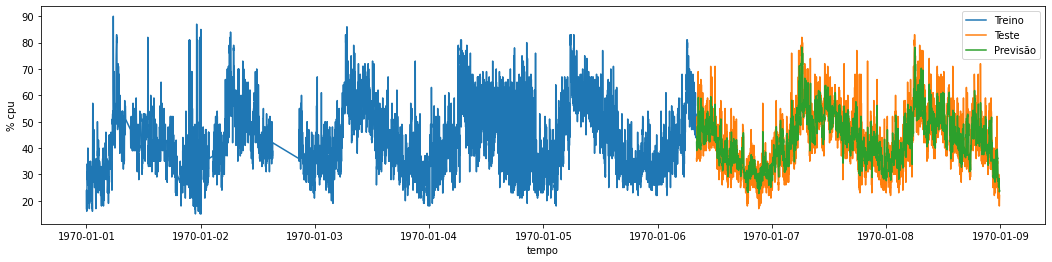

In [5]:
# Gráfico da previsão x teste
result = workload[-test_len+10:-10].copy()
result['predict'] = predict[10:]

plt.figure(figsize=(18,4))
plt.plot(train_set, label = 'Treino')
plt.plot(result['cpu'], label = 'Teste')
plt.plot(result['predict'], label = 'Previsão')
plt.xlabel('tempo')
plt.ylabel('% cpu')
plt.legend()
plt.show()

In [6]:
mse(result['cpu'], result['predict'])

35.85126505588178

In [ ]:
result